In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/essay-score/all_prompts.csv
/kaggle/input/essay-score/train.csv
/kaggle/input/essay-score/test.csv


In [2]:
import tensorflow as tf
from tensorflow import keras

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional

2021-09-19 09:09:49.739768: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0


In [3]:
data=pd.read_csv("../input/essay-score/train.csv")
data.head()

Unnamed: 0  promptId uniqueId  \
0           0         1    1_323   
1           1         1    1_238   
2           2         1    1_212   
3           3         1    1_117   
4           4         1    1_229   

                                               essay  evaluator_rating  
0  At present age, our education system is not go...               3.0  
1  I am agree the tightly defined curriculum of o...               4.0  
2  I strongly agree with the statement that tight...               2.0  
3  Our education system is nice quitely but i dis...               2.0  
4  i am totally agree with the statement that tig...               3.0

In [4]:
data['essay'][100]

"Now a days education is something like commit to memory and vomit to the paper at the exam hall. We overlook quality for quantity. For that our knowledge is limited between the pages of the books. Bookish knowledge is not all we should be bother about. Only the marks are not important in life, we must be able to think for some new ideas. But the current education system doesn't allow us this scope. Academic success that is all we think, we dream, we live in. Our idea is that chasing behind success, winning the mice race is all in life. But no, this is not what life is all about. A student now a days wake up in the morning, then he goes for his tuitions, from there he goes to school or college, again tution. We are bound in a chain system. But we need to get ourselves out of this chain. The students of this generation have turned their faces from outdoor games, imagining new creative ideas or some adventural sports. All of their target is to get high class degree and settle in abroad w

In [5]:
data.columns

Index(['Unnamed: 0', 'promptId', 'uniqueId', 'essay', 'evaluator_rating'], dtype='object')

In [6]:
data['evaluator_rating'].unique()

array([3. , 4. , 2. , 2.5, 0.5, 3.5, 0. , 4.5, 1. , 1.5, 5. ])

In [7]:
data.drop(['Unnamed: 0', 'promptId', 'uniqueId'],axis=1,inplace=True)
data.head()

essay  evaluator_rating
0  At present age, our education system is not go...               3.0
1  I am agree the tightly defined curriculum of o...               4.0
2  I strongly agree with the statement that tight...               2.0
3  Our education system is nice quitely but i dis...               2.0
4  i am totally agree with the statement that tig...               3.0

In [8]:
print(f"The shape of the data is: {data.shape}")
print(f"80% of training data is: {len(data)*0.8}")

The shape of the data is: (1240, 2)
80% of training data is: 992.0


In [9]:
training_size=992
training_sentences=data['essay'][:training_size]
training_labels=data['evaluator_rating'][:training_size]

testing_sentences=data['essay'][training_size:]
testing_labels=data['evaluator_rating'][training_size:]

In [10]:
tokenizer=Tokenizer(num_words=1000, oov_token="<OOV>")
tokenizer.fit_on_texts(training_sentences)

word_index=tokenizer.word_index

training_sequences=tokenizer.texts_to_sequences(training_sentences)
training_padded=pad_sequences(training_sequences,maxlen=400,padding='post',truncating='post')

testing_sequences=tokenizer.texts_to_sequences(testing_sentences)
testing_padded=pad_sequences(testing_sequences,maxlen=400,padding='post',truncating='post')

In [11]:
print(training_padded.shape)
print(testing_padded.shape)

(992, 400)
(248, 400)


In [12]:
print(training_padded[0])
print("******************"*4)
print(testing_padded[0])

[ 92 197 375  16  26  43   6  19  67  49  24  50  63   9 160  37   6  19
 510  26   1  19  52 449  11  24  50   1   7 197  45  62 260 107  25 222
  12  50 347  14 221   3 785  17 309   5   1   1  60   4  18 221   3 128
  26   3 143  32   1 375  87   6   2 149   5  16  60 444 167  99  12  27
  68 160  27  52  28  45   7 285   4 568 480  32   1  18 190   3  84  18
  52  28  12 480  35   1   4   1   4   7 493  18  19 136  32  19 188   3
  52  28  12 101  82 986  73   4   2 600   1 445  44   1  16  26  43   6
  52 449   7   1 286 310   1  49   7  12 203  40  85   1  11  27  52   4
  18 160   1  44   1 103  18  47  19  90   3 280  19   1  25  15  46  19
 671  67   7 102 286 310  49   7  12 203   1 939  19   1   2  52   5 546
 939  18 281  11  73  11  27  52  15   6   2  12  26  43  19 128   1   3
 915   1  92 197  26  43 579  29 522  72  53  22 162  11   1  18 247  69
 343  28   2  34   4  34 987  10  22 221   3   2 343   3   2   1   5   2
  84  19  11 987 116  10 343  28   1 121  84   1  5

In [13]:
model=tf.keras.Sequential()
model.add(Embedding(1000, 54))
model.add(Bidirectional(LSTM(64,return_sequences=True, dropout=0.5, input_shape=(training_padded.shape[1], training_padded.shape[-1]))))
model.add(Bidirectional(LSTM(20, dropout=0.5,return_sequences=True)))
model.add(Bidirectional(LSTM(20, dropout=0.5)))
model.add(Dense(150,activation='relu'))
model.add(Dense(150,activation='relu'))
model.add(Dense(175,activation='relu'))
model.add(Dense(175,activation='relu'))
model.add(Dense(175,activation='relu'))
model.add(Dense(175,activation='relu'))
model.add(Dense(125,activation='relu'))
model.add(Dense(125,activation='relu'))
model.add(Dense(25,activation='relu'))
model.add(Dense(1,activation='relu'))

2021-09-19 09:09:54.259600: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2021-09-19 09:09:54.262990: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2021-09-19 09:09:54.310824: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-09-19 09:09:54.311496: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:00:04.0 name: Tesla P100-PCIE-16GB computeCapability: 6.0
coreClock: 1.3285GHz coreCount: 56 deviceMemorySize: 15.90GiB deviceMemoryBandwidth: 681.88GiB/s
2021-09-19 09:09:54.311584: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
2021-09-19 09:09:54.344696: I tensorflow/stream_executor/platform/def

In [14]:
model.compile(loss='mean_absolute_error',optimizer='adam',metrics=['accuracy'])

In [15]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 54)          54000     
_________________________________________________________________
bidirectional (Bidirectional (None, None, 128)         60928     
_________________________________________________________________
bidirectional_1 (Bidirection (None, None, 40)          23840     
_________________________________________________________________
bidirectional_2 (Bidirection (None, 40)                9760      
_________________________________________________________________
dense (Dense)                (None, 150)               6150      
_________________________________________________________________
dense_1 (Dense)              (None, 150)               22650     
_________________________________________________________________
dense_2 (Dense)              (None, 175)               2

In [16]:
print(training_padded.shape)
print(training_labels.shape)

(992, 400)
(992,)


In [17]:
history=model.fit(training_padded,training_labels,epochs=250,verbose=2)

Epoch 1/250


2021-09-19 09:09:57.720113: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2021-09-19 09:09:57.730121: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2000189999 Hz
2021-09-19 09:10:04.566236: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.11
2021-09-19 09:10:05.355823: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublasLt.so.11
2021-09-19 09:10:05.398457: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudnn.so.8


31/31 - 16s - loss: 1.2904 - accuracy: 0.0282
Epoch 2/250
31/31 - 3s - loss: 0.7596 - accuracy: 0.0252
Epoch 3/250
31/31 - 3s - loss: 0.7262 - accuracy: 0.0252
Epoch 4/250
31/31 - 3s - loss: 0.6396 - accuracy: 0.0252
Epoch 5/250
31/31 - 3s - loss: 0.6432 - accuracy: 0.0252
Epoch 6/250
31/31 - 3s - loss: 0.5799 - accuracy: 0.0252
Epoch 7/250
31/31 - 3s - loss: 0.6384 - accuracy: 0.0252
Epoch 8/250
31/31 - 3s - loss: 0.6436 - accuracy: 0.0252
Epoch 9/250
31/31 - 3s - loss: 0.5260 - accuracy: 0.0252
Epoch 10/250
31/31 - 3s - loss: 0.5042 - accuracy: 0.0252
Epoch 11/250
31/31 - 3s - loss: 0.4636 - accuracy: 0.0252
Epoch 12/250
31/31 - 3s - loss: 0.4394 - accuracy: 0.0252
Epoch 13/250
31/31 - 3s - loss: 0.4411 - accuracy: 0.0252
Epoch 14/250
31/31 - 3s - loss: 0.4043 - accuracy: 0.0302
Epoch 15/250
31/31 - 3s - loss: 0.4121 - accuracy: 0.0363
Epoch 16/250
31/31 - 3s - loss: 0.4237 - accuracy: 0.0403
Epoch 17/250
31/31 - 3s - loss: 0.4540 - accuracy: 0.0252
Epoch 18/250
31/31 - 3s - loss: 0.

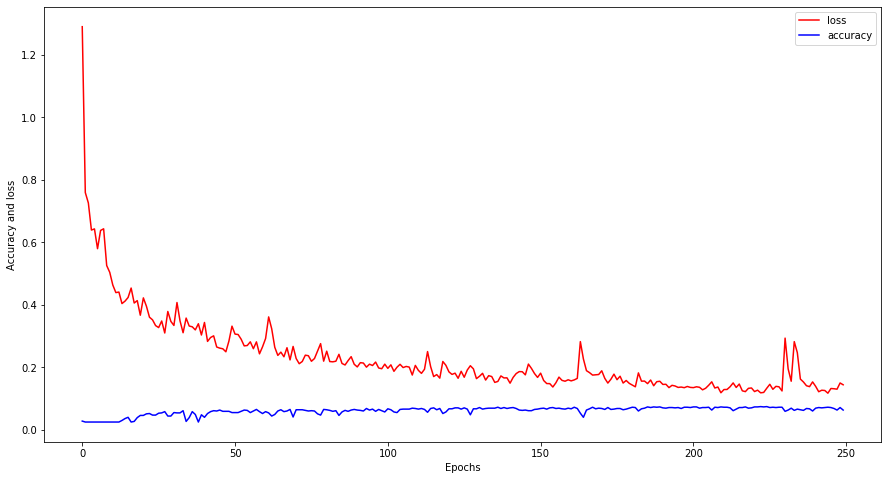

In [18]:
import matplotlib.pyplot as plt
plt.figure(figsize=(15,8))
plt.xlabel('Epochs')
plt.ylabel("Accuracy and loss")
plt.plot(history.history['loss'],'r-',label='loss')
plt.plot(history.history['accuracy'],'b-',label='accuracy')
plt.legend()

In [19]:
testing_padded[0]

array([  7,  17,   1, 220,  48,   9,   1,  11,  93, 635,   7,  27,   1,
       235,  40,   2, 129,   9, 598,   3,  74, 255,   7,   2,  48,   4,
       598,   3, 754,  40,  65, 129,  11,   1,  27, 131,   7,   1,  95,
       399,   9, 598,   3, 372,  41, 447,   1,  27, 126,   1,   2,   1,
         9,  24, 371,  11,   1,  41, 125, 222,   2, 623,  48, 333, 129,
         9,   1,  11,   1,  27, 131,   3,  40, 256,   2,  48, 647, 623,
        48, 333, 690,   1,   8,   1, 635,   7, 621,   4,  15, 909, 239,
       756,   3,   1,   1, 340,   1,   9,  34, 385,   1,   4,  35,  12,
       878,  18,   9, 289,  41, 109,  51,   8,   1,  48, 333, 174, 825,
         2, 545,  48,  22,  20,   1,  35,  17,   1, 109,  24, 666, 210,
        79, 198, 109,  10,  23,   3,  90, 202,  79,   1,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   

In [20]:
y_predicted=model.predict(testing_padded)

In [21]:
predictions=pd.DataFrame(y_predicted,columns=['predictions'])
test_labels=testing_labels.to_frame()
test_labels.reset_index(inplace=True,drop=True)
predictions.head()

predictions
0     2.870289
1     2.084678
2     2.722469
3     2.818978
4     3.472972

In [22]:
pd.concat([test_labels,predictions],axis=1)

evaluator_rating  predictions
0                 3.0     2.870289
1                 0.0     2.084678
2                 2.0     2.722469
3                 3.0     2.818978
4                 2.5     3.472972
..                ...          ...
243               3.0     2.084299
244               2.5     3.249586
245               4.0     3.886282
246               3.0     0.911393
247               4.5     3.008616

[248 rows x 2 columns]

In [23]:
model.evaluate(testing_padded,testing_labels)

8/8 [==============================] - 2s 43ms/step - loss: 1.0308 - accuracy: 0.0323


[1.0307807922363281, 0.032258063554763794]

In [24]:
model.save('lstm_model_essay.h5')

In [25]:
test=pd.read_csv("../input/essay-score/test.csv")
test.head()

Unnamed: 0  promptId uniqueId  \
0           0         1    1_315   
1           1         1    1_214   
2           2         1    1_196   
3           3         1    1_178   
4           4         1    1_201   

                                               essay  
0  Curriculum has been adopted in many schools. T...  
1  I strongly agree with the statement ,  The tig...  
2  Imagination and creativity is the most importa...  
3  In our eduction system leaves no room for imag...  
4  I will agree at some what extend, because if w...

In [26]:
test.drop(['Unnamed: 0', 'promptId', 'uniqueId'],axis=1,inplace=True)

In [27]:
test_essay_data=test['essay']

In [28]:
testing_sequences_data=tokenizer.texts_to_sequences(test_essay_data)
testing_data=pad_sequences(testing_sequences_data,maxlen=400,padding='post',truncating='post')

In [29]:
test_predicted_data=model.predict(testing_data)

In [32]:
test_predicted_data

array([[3.1494632 ],
       [2.9283078 ],
       [3.424321  ],
       [2.7070048 ],
       [3.2421556 ],
       [2.3491716 ],
       [2.841096  ],
       [3.3847156 ],
       [2.429577  ],
       [3.3467536 ],
       [2.51199   ],
       [2.7104552 ],
       [3.4950898 ],
       [3.43343   ],
       [3.341043  ],
       [3.1740408 ],
       [2.6619878 ],
       [3.3323348 ],
       [2.2227602 ],
       [3.6846967 ],
       [3.2878103 ],
       [3.5316598 ],
       [2.5572207 ],
       [2.7434201 ],
       [3.3790188 ],
       [3.4249103 ],
       [1.3295727 ],
       [3.380907  ],
       [3.4638917 ],
       [3.356971  ],
       [3.4520245 ],
       [3.3779168 ],
       [2.5504987 ],
       [3.2814765 ],
       [3.107312  ],
       [2.410987  ],
       [3.0211666 ],
       [3.089409  ],
       [2.8729787 ],
       [3.537912  ],
       [2.2524607 ],
       [3.4550686 ],
       [3.1493995 ],
       [2.8264236 ],
       [2.8693542 ],
       [2.7524848 ],
       [3.7968216 ],
       [2.266

In [40]:
test_predicted_data_csv=pd.DataFrame(test_predicted_data,columns=['LSTM_predictions'])
test_predicted_data_csv.head()

LSTM_predictions
0          3.149463
1          2.928308
2          3.424321
3          2.707005
4          3.242156

In [41]:
test_predicted_data_csv.to_csv('LSTM_1',index=False)

In [38]:
pd.concat([test,test_predicted_data_csv],axis=1)

essay  LSTM_predictions
0    Curriculum has been adopted in many schools. T...          3.149463
1    I strongly agree with the statement ,  The tig...          2.928308
2    Imagination and creativity is the most importa...          3.424321
3    In our eduction system leaves no room for imag...          2.707005
4    I will agree at some what extend, because if w...          3.242156
..                                                 ...               ...
300  Earth is a creation of God and everything that...          3.172905
301  production of arms and weapons in this present...          1.696128
302  Race to become more powerful can destroy the e...          1.649963
303  In its attempt to harness the power of the ato...          2.725395
304  Racein the production of arms and weapons in t...          1.602036

[305 rows x 2 columns]